# RK Model 
- The model is an attempt to understand the influence of physical processes in cold regions. A 2-D transect along the Yakou catchement (Tibetan Plateau, Heihe river basin) is the field site.   
- The notebook describes the model configurations, extracts the output and plots it. 

### Brief description:

- Goal – To freezeup column from bottom until top. (Check how to freeze until 1 m from the top)
- T : 1000 years 
- Processes: Subsurface permafrost - flow, energy
- Mesh: Pseudo 1-D column with three layers - organic, mineral, and bedrock layer with increasing cell sizes.
- Initial conditions : -11.0 m – hydrostatic head (in m), 273.65 K – Temperature 
- Boundary conditions :  Linear temperature variation from 273.65 --> 264.15 from 0 --> 1000 days

- Parameters:
    - VGc - Peat: alpha – 0.0005, n – 1.39, S_res = 0.05
    - VGc - Mineral & Bedrock: alpha – 2e-05, n – 1.58, S_res = 0.2
    - Thermal conductivity: Peat – L_dry – 0.07 W m^-1 K^-1, alpha_frozen = 1.0, alpha_unfrozen = 0.5
    - Thermal conductivity: Mineral & Bedrock – L_dry – 0.29 W m^-1 K^-1, alpha_frozen = 1.0, alpha_unfrozen = 0.5
    - Porosity, Compressible porosity: Peat – 0.85, 1e-07 Pa^-1; Mineral – 0.5, 1e-08 Pa^-1;
    - Permeability: Peat – 5e-11 m^2, Mineral & Bedrock – 2e-13 m^2 
    - Density: Peat – 700 kg/m^3, Mineral & Bedrock – 2170 kg/m^3

- Observations:
    - Temperature [K] @ 0.01 m, 0.04 m, 0.1 m, 0.2 m, 0.4 m, 0.8 m, 1.2 m, 1.6 m 5 m, 10 m, 20 m, 30 m, 40 m.
    - Saturation liquid [%] @ 0.01 m, 0.04 m, 0.1 m, 0.2 m, 0.4 m, 0.8 m, 1.2 m, 1.6 m 5 m, 10 m.
    - Saturation ice [%] @ 0.01 m, 0.04 m, 0.1 m, 0.2 m, 0.4 m, 0.8 m, 1.2 m, 1.6 m 5 m, 10 m.

- I/O files:
    - Xml file: Case1B_I.xml
    - Output folder (.demo file): Case1B_I.demo

- Expected results: Intially the temperature of the column is set to 0.5°C and the initial hydrostatic head is -11 m (from the surface, the water level will at 11 m depth from the surface) When the simulations starts, the temperature will drop from below and slowly this temperature drop will initiate freezing around 0°C. This freezing front will develop from the bottom to the top over the course of the simulation.

### Detailed description:

#### 1. Physical processes - Cases: Case 1
The physical processes that are considered - Subsurface flow + Subsurface energy (with ice content). A custom strong coupler - 'subsurface permafrost' couples the 'permafrost flow' and 'three-phase energy' PKs. 

<img src='../figures/Case1_process.jpg' width='500' height='500' alt='Case1 physical process' align='center' />  




#### 2. Mesh - Stages: Stage B
Two types of meshes are considered here. The first mesh (Yakou_column.exo) resembles the properties of the hillslope transect that we would like to simulate. Once the meshing issues are resolved,we will be using this mesh. The second mesh is a test mesh that was generated by the ATS developers with similar properties. We will be using this mesh. 

1. Yakou_column.exo - Organic layer (0.25 m), Mineral layer (0.25 - 20 m), Bedrock (20 – 40 m) with increasing cell thickness. [Cell thickness: 0.05 m until 0.25 m (Organic layer); 0.05 m until 0.25 m and increasing cell size by 2 units until 2 m, 2 m - 20 m, we have 2 m cell sizes (Mineral layer); we again have 2 m cell sizes from 20 m - 40 m]

2. tes_org_spinup_column.exo - Organic layer (0.385 m), Mineral layer (2.24 m), Bedrock (42.48 m); Cell thickness starts with a magnitude of 0.01 m and increases in magnitude of 1.2, 1.4 & 1.5 as cell numbers increase from 20, 20 - 26, and >26. 

##### Mesh - Run it with yakou_column.xml once the meshing issues has been resolved.  

Images of 'tes_org_spinup_column.exo':

<img src='../figures/1D_test_org_spinup_column_1.PNG' width='70' height='90' alt='1D_test_org_column_1' align='left' />  

<img src='../figures/1D_test_org_spinup_column_2.PNG' width='120' height='200' alt='1D_test_org_column_2' align='center' />  





#### 3. Scenarios (IC, BC): Scenario I


| :------:               | IC   |  BC    |                 
| :----------------------------------------------------------------- | :------: | :------: |  
| Hydraulic                                                          | Hydrostatic head (-11 m) | - |
| Thermal                                                            | 273.65 K (0.5 °C)   |  BottomlinearT = Linear temperature variation from 273.65 --> 264.15 from 0 --> 1000 days |

##### Time period (T) of 1000 years is selected.


#### 4. Parameters:


|Sl. No.|	Parameter type|	Parameter|	Unit|	Soil type/Water	|Current value|
| --- | --- | --- | --- | --- | --- |
1 |	Variably saturated properties - van Genuchten model |	van Genuchten alpha |	Pa^{-1} |	Peat |	0.0005 |
2 |	Variably saturated properties - van Genuchten model |	van Genuchten n |	[-] | Peat |		1.39
3 |	Variably saturated properties - van Genuchten model |	residual saturation	| [-] | Peat |		0.05
4 |	Variably saturated properties - van Genuchten model |	smoothing interval width 	| [saturation] | Peat |		0.05
5 |	Variably saturated properties - van Genuchten model |	van Genuchten alpha	Pa^{-1} | Mineral |	0.0005
6 |	Variably saturated properties - van Genuchten model |	van Genuchten n	| [-]	| Mineral |		1.39
7 |	Variably saturated properties - van Genuchten model |	residual saturation	| [-]	| Mineral |		0.05
8 |	Variably saturated properties - van Genuchten model |	smoothing interval width  |	[saturation] | Mineral |			0.05
9 |	Variably saturated properties - van Genuchten model |	van Genuchten alpha	| Pa^{-1}	| Bedrock |	2.00E-05
10 | Variably saturated properties - van Genuchten model |		van Genuchten n	| [-] | Bedrock |	1.58
11 | Variably saturated properties - van Genuchten model |		residual saturation	| [-]	| Bedrock |	0.2
12 | Variably saturated properties - van Genuchten model |		smoothing interval width 	| [saturation] | Bedrock |		0.05
13 | 	Permafrost model parameters - fpd permafrost model [Cryosuction] |	minimum dsi_dpressure magnitude |	??	| For the entire model |	1.00E-12 |
14 |	Thermal conductivity evaluator: Three-phase wet/dry |	Thermal conductivity, saturated (unfrozen) | 	[W m^-1 K^-1] |	Peat |	0.67 |
15 |	Thermal conductivity evaluator: Three-phase wet/dry |	Thermal conductivity, dry 	| [W m^-1 K^-1] |	Peat |		0.07 |
16 |	Thermal conductivity evaluator: Three-phase wet/dry |	Unsaturated alpha frozen	| [-]	 |	Peat |	1 |
17 |	Thermal conductivity evaluator: Three-phase wet/dry |	Unsaturated alpha unfrozen	| [-]	|	Peat |	0.5 |
18 |	Thermal conductivity evaluator: Three-phase wet/dry |	Thermal conductivity, saturated (unfrozen) | 	[W m^-1 K^-1] |	Mineral |	1 |
19 |	Thermal conductivity evaluator: Three-phase wet/dry |	Thermal conductivity, dry | [W m^-1 K^-1] |	Mineral |		0.29 |
20 |	Thermal conductivity evaluator: Three-phase wet/dry |	Unsaturated alpha frozen| [-] |	Mineral |		1 |
21 |	Thermal conductivity evaluator: Three-phase wet/dry |	Unsaturated alpha unfrozen | [-] |	Mineral |		0.5 |
22 |	Thermal conductivity evaluator: Three-phase wet/dry |	Thermal conductivity, saturated (unfrozen) |	[W m^-1 K^-1] |	Bedrock |	1 |
23 |	Thermal conductivity evaluator: Three-phase wet/dry |	Thermal conductivity, dry 	| [W m^-1 K^-1] |	Bedrock |		0.29 |
24 |	Thermal conductivity evaluator: Three-phase wet/dry |	Unsaturated alpha frozen	| [-]	 |	Bedrock |	1 |
25 |	Thermal conductivity evaluator: Three-phase wet/dry |	Unsaturated alpha unfrozen	| [-] |	Bedrock |		0.5 |
39 |	Physical |	Base porosity |	[-] |	Peat |	0.85 |
40 |	Physical |	Base porosity |	[-]	 | Mineral |	0.5 |
41 |	Physical |	Base porosity | [-]	| bedrock	 | 0.5 |
42 |	Physical |	Pore compressibility	| [Pa^-1] |	Peat |	1.00E-07 |
43 |	Physical |	Pore compressibility	| [Pa^-1] |	Mineral |	1.00E-08 |
44 |	Physical |	Pore compressibility	| [Pa^-1] |	bedrock |	1.00E-08 |
45 |	Physical / Hydraulic |	Permeability	| m^2? |	Peat |	5.00E-11 |
46 |	Physical / Hydraulic |	Permeability	|m^2? |	Mineral |	2.00E-13 |
47 |	Physical / Hydraulic |	Permeability	| m^2? |	bedrock |	2.00E-13 |
48 |	Physical |	Density	| kg/m^3? |	Peat |	7.00E+02 |
49 | 	Physical |	Density	|kg/m^3? |	Mineral |	2.17E+03 |
50 |	Physical |	Density	|kg/m^3? |	bedrock |	2.17E+03 |

- The values of Bedrock are currently similar to that of Minerals. While conducting the parameter sensitivity analysis, the values will be changed.

#### 5. Visualization:

- The entire subsurface domain is visualized. 
- Cycles start period stop" - "{0,100,-1}". (Every 100 units of 1000 years - one simulation results is dumped?)

#### 6. Observations:

- The variables under observation: 

    - Temperature [K] @ 0.01 m, 0.04 m, 0.1 m, 0.2 m, 0.4 m, 0.8 m, 1.2 m, 1.6 m 5 m, 10 m, 20 m, 30 m, 40 m.
    - Saturation liquid [%] @ 0.01 m, 0.04 m, 0.1 m, 0.2 m, 0.4 m, 0.8 m, 1.2 m, 1.6 m 5 m, 10 m.
    - Saturation ice [%] @ 0.01 m, 0.04 m, 0.1 m, 0.2 m, 0.4 m, 0.8 m, 1.2 m, 1.6 m 5 m, 10 m.


#### I/O files:

- Xml file: Case1B_I.xml
- Output folder (.demo file): Case1B_I.demo

## Ethan's note: spinup1: Freeze steady-state to generate ice column

 Transient simulations are initialized in the winter to make spinup simpler.  Therefore we start from a fully frozen domain (instead of the partially frozen domain that would be required for starting any other time of year).  

To establish this fully-frozen domain, we freeze the hydrostatic water column from below until the solution reaches steady-state again.  This "pseudo-transient" approach is easier for solvers than solving the steady-state problem.  This is done in the subsurface only, solving coupled Richards and energy equations.

The bottom boundary temperature is set at -9 F, which is, according to deep borehole data, a reasonable temperature for deep permafrost in Barrow.  As the column freezes, water expands to form ice, pushing the water above it up.  This results in a careful balance -- we want to set the bottom pressure in spinup0 such that, when frozen, the ice table is near the surface, but not above it (which would break the problem here because a no flux condition is put on that top surface).  The calculation of such a pressure is difficult, as it depends upon soil properties, freezing rates, and other dynamic things, so a test-and-check approach is taken.

First, a bottom pressure is set for spinup0, then frozen from below in spinup1.  If the resulting ice table is too high, the pressure in the top cell will blow up, and the process is repeated with a smaller bottom pressure in spinup0.   If the resulting ice table is too low, the entire active layer will happen in an unsaturated zone, and the soil will never saturate.  Typically, for coastal polygonal permafrost, the soil is quite wet, so we work to get the ice table as close to the surface as possible.  More thought might be required for a drier condition, but remember that too wet is rarely an issue (things can drain over a few dynamic years fairly quickly as long as they thaw, but filling up from too dry takes a much longer time).  Bisection on the spinup0 bottom pressure can be used to quickly find a pressure that hits an appropriate ice table level.

NOTE: From here on, transient problems are plotted such that early times have low intensity colors, and late times are high intensity colors.

NOTE: This run takes some time (especially if the code is built in debug mode), ~10 minutes.

## Workflow:
1. Importing all the modules
2. Plotting with the ats output code.
3. Plotting the visualization results.
4. Preparing the final results as initial conditions for another model 
4. Plotting the observation results.

### 1. Importing all the modules

In [26]:
%matplotlib inline
import sys,os

sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
#sys.path.append(os.path.join('/home/rk/ats_rk/amanzi/src/physics/ats/tools/utils'))
import ats_xdmf
import plot_column_data
import colors
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt

In [27]:
import h5py
import pandas as pd

In [28]:
import os
print(os.getcwd())

/home/rk/ats_rk/testing/ats-demos/rk_model/Case1_B


In [29]:
# Output directory name & input xml file name:
file_name = '/home/rk/ats_rk/testing/ats-demos/rk_model/Case1_B/Case1_B_I.demo'
input_filename = '/home/rk/ats_rk/testing/ats-demos/rk_model/Case1_B/Case1_B_I.xml'

### 2. Plotting with the ATS output code

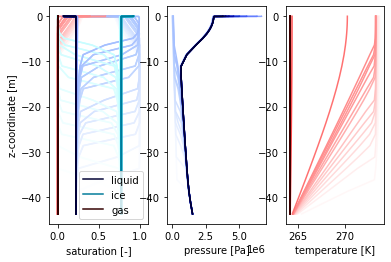

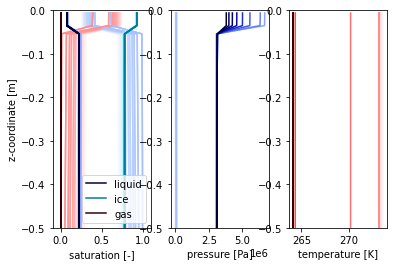

In [30]:
def plot(dirname, axs):
    """A generic plotting function that plots saturation as a function of depth."""

    plot_column_data.plot_subsurface(vis, ['pressure',], axs[0], cmap='jet')
    axs[0].set_xlabel('pressure [Pa]')
    ax.set_ylabel('z [m]')
    
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], axs[1], None, cmap='jet')
    axs[0].set_xlabel('saturation [-]')
    ax.set_ylabel('z [m]')

def plot(file_name, axs, style):
    # load the data
    vis = ats_xdmf.VisFile(file_name, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
    times = vis.times
    
    ice = colors.cm_mapper(-10, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = vis.centroids[:,2]
    for i,t in enumerate(times):
        label = False
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
        axs[2].plot(dati[5,i,:],z, style, color=gas(t))
        axs[1].plot(dati[1,i,:],z, style, color=water(t))
        axs[0].plot(dati[2,i,:],z, style, color=water(t))
        axs[0].plot(dati[3,i,:],z, style, color=ice(t))
        axs[0].plot(dati[4,i,:],z, style, color=gas(t))

def decorate(axs):
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[1].set_xlabel('pressure [Pa]')
    axs[2].set_xlabel('temperature [K]')
    axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axs[0].set_xlim([-.1,1.1])
    axs[0].legend()


# full column
fig, axs = plt.subplots(1,3)
plot(file_name, axs, '-')
decorate(axs)

# and a zoomed version
fig, axs = plt.subplots(1,3)
plot(file_name, axs, '-')
decorate(axs)
axs[0].set_ylim([-0.5,0])
axs[1].set_ylim([-0.5,0])
axs[2].set_ylim([-0.5,0])


plt.show()
            

In [31]:
# load the ATS solution
directory = f"{file_name}"
vis = ats_xdmf.VisFile(directory)
vis.loadMesh(columnar=True)

### 3. Plotting the visualization results

#### Extracting the names of the dataset:

In [32]:
### Extracting the subsurface data
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    porosity = hdf.get('base_porosity.cell.0')
    print(porosity)

List of datasets in this file: 
 
 ['base_porosity.cell.0', 'capillary_pressure_gas_liq.cell.0', 'capillary_pressure_liq_ice.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'density_rock.cell.0', 'dwater_content|dtemperature.cell.0', 'energy.cell.0', 'enthalpy.cell.0', 'enthalpy_times_relative_permeability.cell.0', 'internal_energy_ice.cell.0', 'internal_energy_liquid.cell.0', 'internal_energy_rock.cell.0', 'mass_density_liquid.cell.0', 'molar_density_ice.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_ice.cell.0', 'saturation_liquid.cell.0', 'temperature.cell.0', 'thermal_conductivity.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']


<HDF5 group "/base_porosity.cell.0" (22 members)>


#### Determining the time instances at which the data is stored

In [33]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        print(time_period)
        print(len(time_period))
        # Time series stored in an irregular format! - 
        # ['0' '100' '103' '104' '105' '106' '107' '108' '109' '110' '111']

[   0  100 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900  200 2000
 2100  300  400  500  600  700  800  900]
22


#### Recreating the node information of the cells:
- The centroidal distance was calculated while generating the ats mesh - rk_model/Data/data_mesh/hillslope_example.ipynb
- And stored in the file : /home/rk/ats_rk/testing/ats-demos/rk_model/Data/data_mesh/test_org_column_centroidal_dist.csv

In [34]:
dz_hillslope = pd.read_csv('/home/rk/ats_rk/testing/ats-demos/rk_model/Data/data_mesh/test_org_column_centroidal_dist.csv',header=None)
# Renaming the column:
dz_hillslope.columns = ['centroidal_distance']
dz_hillslope.head()

,centroidal_distance
0,0.006000
1,0.019200
2,0.035040
3,0.054048
4,0.076858


In [35]:
# Storing the negative of the centroidal distance as we are going downwards
z = -dz_hillslope['centroidal_distance']

In [36]:
print(z.head())

0   -0.006000
1   -0.019200
2   -0.035040
3   -0.054048
4   -0.076858
Name: centroidal_distance, dtype: float64


In [37]:
def inputfiles_pddataframes(file_name,t,z):
    """
    The function is defined to read the input files from the ats simulation. 
    For each time instance, a dataframe can store the data.
 
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    t : The time instance at which the data is required.
    Ex: cell_volume.cell.0/{t} - here 0/0 - signifies the first directory (with data at t=0), 
    similarly 0/1 - signifies the second directory (with data at t=1).
            
    Output parameters:
    
    data_results : pandas dataframe with all the key elements of the simulation.
    
    - idea - can't we write a smart function that directly accesses all the columns? - !
    
    """
    
    
    with h5py.File(file_name,'r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0/{t}'))
        cell_volume = cell_volume_all.flatten()
        
        
        # Storing the variables/constants in a dataframe - Do we have a direct function to do this? 
        # Can we simplify the code?
        
        data_results = pd.DataFrame(index=z,data=cell_volume,columns=['cell_volume'])

        mass_density_all = np.array(hdf.get(f'mass_density_liquid.cell.0/{t}'))
        mass_density = mass_density_all.flatten()
        data_results['mass_density [rho_l] [kg m^{-3}]'] = mass_density



        molar_density_all = np.array(hdf.get(f'molar_density_liquid.cell.0/{t}'))
        molar_density = molar_density_all.flatten()
        data_results['molar_density [n_l] [mol m^{-3}]'] = molar_density


        permeability_all = np.array(hdf.get(f'permeability.cell.0/{t}'))
        permeability = permeability_all.flatten()
        data_results['Absolute permeability [K] (m^{2})'] = permeability



        porosity_all = np.array(hdf.get(f'porosity.cell.0/{t}'))
        porosity = porosity_all.flatten()
        data_results['Porosity [phi] (-)'] = porosity

        pressure_all = np.array(hdf.get(f'pressure.cell.0/{t}'))
        pressure = pressure_all.flatten()
        data_results['Abs pressure [p_abs] [Pa]'] = pressure 
        # Water pressure or total pressure (Atm + water)? - Probably both

        relative_permeability_all = np.array(hdf.get(f'relative_permeability.cell.0/{t}'))
        relative_permeability = relative_permeability_all.flatten()
        data_results['Relative permeability [kr] [-]'] = relative_permeability


        saturation_gas_all = np.array(hdf.get(f'saturation_gas.cell.0/{t}'))
        saturation_gas = saturation_gas_all.flatten()
        data_results['Saturation of gas [s_g] [-]'] = saturation_gas


        saturation_liquid_all = np.array(hdf.get(f'saturation_liquid.cell.0/{t}'))
        saturation_liquid = saturation_liquid_all.flatten()
        data_results['Saturation of liquid [s_l] [-]'] = saturation_liquid


        
        saturation_ice_all = np.array(hdf.get(f'saturation_ice.cell.0/{t}'))
        saturation_ice = saturation_ice_all.flatten()
        data_results['Saturation of ice [s_i] [-]'] = saturation_ice
        
        temperature_all = np.array(hdf.get(f'temperature.cell.0/{t}'))
        temperature = temperature_all.flatten()
        data_results['Temperature [T] [K]'] = temperature


        viscosity_liquid_all = np.array(hdf.get(f'viscosity_liquid.cell.0/{t}'))
        viscosity_liquid = viscosity_liquid_all.flatten()
        data_results['viscosity_liquid [v] Pas]'] = viscosity_liquid


        water_content_all = np.array(hdf.get(f'water_content.cell.0/{t}'))
        water_content = water_content_all.flatten()
        data_results['water_content [theta] mols'] = water_content
        
        return data_results

##### Storing the data for all time instances

In [38]:
for i in time_period:
    # https://stackoverflow.com/questions/1060090/changing-variable-names-with-python-for-loops
    locals()["data_results_"+str(i)] = inputfiles_pddataframes(file_name=f'{file_name}/ats_vis_data.h5', t=i,z=z)

#### Defining a dataframe that extracts the data for a single variable for all time instances

In [39]:
def input_datavar(file_name, variable, z):
    """
    The function defined to extract a variable across all time instances.
    
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    variable: Name of the variable in the dataset that you are interested in.
    Ex: 'cell_volume'
    
    Output parameters:
    
    data_var : pandas dataframe with the time series data of the variable.
    
    """
    
    # To determine the time period and the list in which the dataframes 
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/0'))
        var_0 = var_all_0.flatten()
        data_var = pd.DataFrame(index=z,data=var_0,columns=[f'0'])
        
        for i in time_period[1:]:
            var_all = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var = var_all.flatten()
            
            data_var[f'{i}'] = var
    
    return data_var

In [40]:
### Accessing the variable at all time instances

### Add or remove variable name if required
variables = ['saturation_liquid','saturation_ice','saturation_gas','pressure','relative_permeability','temperature']

for i in variables:
    locals()["df_"+str(i)] = input_datavar(file_name, i, z=z)
    len_rows = len(locals()["df_"+str(i)].columns)
    locals()["df_"+str(i)].columns = np.arange(0,len_rows,1)

In [41]:
df_pressure.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
centroidal_distance,,,,,,,,,,,,,,,,,,,,,
-0.006000,-6489.310100,6681.023445,13486.190079,20948.820091,25996.246347,30861.402704,35375.019117,40095.031701,49963.358408,55754.470765,...,78655.935899,94370.270931,6.675102e+06,6.341096e+06,5.572024e+06,5.018380e+06,4.590603e+06,4.259682e+06,4.002838e+06,3.805025e+06
-0.019200,-6359.862320,6810.618859,13615.720876,21078.289303,26125.712774,30990.866069,35504.496764,40224.510287,50092.816396,55883.933321,...,78785.388839,94499.713408,6.670218e+06,6.336773e+06,5.568773e+06,5.015898e+06,4.588714e+06,4.258250e+06,4.001762e+06,3.804222e+06
-0.035040,-6204.524984,6966.356726,13771.289256,21233.696583,26281.113285,31146.258932,35659.927319,40379.943333,50248.195388,56039.324235,...,78940.754287,94655.051198,6.657132e+06,6.325183e+06,5.560011e+06,5.009163e+06,4.583544e+06,4.254289e+06,3.998737e+06,3.801917e+06
-0.054048,-6018.120181,7152.764444,13957.691108,21420.091461,26467.507386,31332.652367,35846.322404,40566.338671,50434.588375,56225.718281,...,79127.150330,94841.452034,3.057799e+06,3.141234e+06,3.141930e+06,3.140979e+06,3.139594e+06,3.138030e+06,3.136419e+06,3.134830e+06
-0.076858,-5794.434417,7376.472423,14181.383311,21643.768186,26691.182909,31556.326794,36070.000268,40790.016932,50658.261708,56449.393333,...,79350.827206,95065.134870,3.054905e+06,3.136394e+06,3.137965e+06,3.137787e+06,3.137044e+06,3.136004e+06,3.134816e+06,3.133565e+06


In [42]:
pressure_head_data = df_pressure/(10000)

In [43]:
pressure_head_data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
centroidal_distance,,,,,,,,,,,,,,,,,,,,,
-0.006000,-0.648931,0.668102,1.348619,2.094882,2.599625,3.086140,3.537502,4.009503,4.996336,5.575447,...,7.865594,9.437027,667.510178,634.109575,557.202373,501.837983,459.060334,425.968154,400.283811,380.502520
-0.019200,-0.635986,0.681062,1.361572,2.107829,2.612571,3.099087,3.550450,4.022451,5.009282,5.588393,...,7.878539,9.449971,667.021766,633.677259,556.877287,501.589769,458.871421,425.825046,400.176198,380.422197
-0.035040,-0.620452,0.696636,1.377129,2.123370,2.628111,3.114626,3.565993,4.037994,5.024820,5.603932,...,7.894075,9.465505,665.713230,632.518315,556.001079,500.916348,458.354437,425.428899,399.873691,380.191681
-0.054048,-0.601812,0.715276,1.395769,2.142009,2.646751,3.133265,3.584632,4.056634,5.043459,5.622572,...,7.912715,9.484145,305.779863,314.123445,314.192982,314.097912,313.959373,313.803023,313.641856,313.483043
-0.076858,-0.579443,0.737647,1.418138,2.164377,2.669118,3.155633,3.607000,4.079002,5.065826,5.644939,...,7.935083,9.506513,305.490457,313.639445,313.796514,313.778658,313.704426,313.600433,313.481576,313.356542


Text(0.5, 0, 'Saturation (-)')

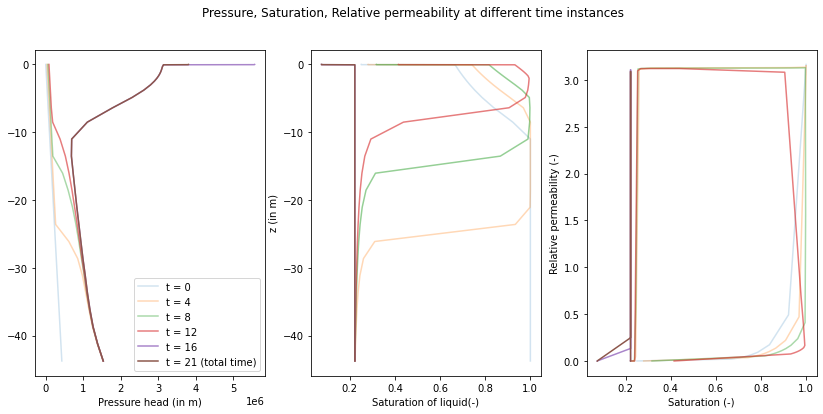

In [44]:
fig, (ax2, ax1, ax3) = plt.subplots(1, 3)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation, Relative permeability at different time instances')

z = df_saturation_liquid.index

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[16], z, alpha=0.8)
ax1.plot(df_saturation_liquid[21], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(df_pressure[0], z, alpha=0.2, label ='t = 0')
ax2.plot(df_pressure[4], z, alpha=0.3, label ='t = 4')
ax2.plot(df_pressure[8], z, alpha=0.4, label ='t = 8')
ax2.plot(df_pressure[12], z, alpha=0.6, label ='t = 12')
ax2.plot(df_pressure[16], z, alpha=0.8, label ='t = 16')
ax2.plot(df_pressure[21], z, alpha=1, label ='t = 21 (total time)')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.legend()

ax3.plot(df_saturation_liquid[0], df_relative_permeability[0], alpha=0.2)
ax3.plot(df_saturation_liquid[4], df_relative_permeability[2], alpha=0.3)
ax3.plot(df_saturation_liquid[8], df_relative_permeability[4], alpha=0.4)
ax3.plot(df_saturation_liquid[12], df_relative_permeability[6], alpha=0.6)
ax3.plot(df_saturation_liquid[16], df_relative_permeability[8], alpha=0.8)
ax3.plot(df_saturation_liquid[21], df_relative_permeability[10], alpha=1)
#ax3.plot(df_saturation_liquid[200], df_relative_permeability[200], alpha=1, label ='t = 2 days')
#ax3.legend()
ax3.set_ylabel('Relative permeability (-)')
ax3.set_xlabel('Saturation (-)')


In [45]:
pressure_head_data[0]

centroidal_distance
-0.006000     -0.648931
-0.019200     -0.635986
-0.035040     -0.620452
-0.054048     -0.601812
-0.076858     -0.579443
-0.104229     -0.552601
-0.137075     -0.520390
-0.176490     -0.481738
-0.223788     -0.435354
-0.280546     -0.379694
-0.348655     -0.312902
-0.430386     -0.232751
-0.528463     -0.136570
-0.646155     -0.021153
-0.787386      0.117347
-0.956863      0.283547
-1.160236      0.482988
-1.404283      0.722317
-1.697140      1.009511
-2.048568      1.354144
-2.470282      1.767704
-3.022343      2.309091
-3.795229      3.067033
-4.877269      4.128152
-6.392126      5.613719
-8.512925      7.693513
-11.008529    10.141311
-13.526500    12.610481
-16.043000    15.079652
-18.550000    17.548822
-21.070000    20.017992
-23.600000    22.487162
-26.117500    24.956333
-28.632500    27.425503
-31.145000    29.894673
-33.664000    32.363844
-36.187000    34.833014
-38.705100    37.302184
-41.222100    39.771355
-43.740000    42.240525
Name: 0, dtype: floa

Text(0.5, 0, 'Temperature (K)')

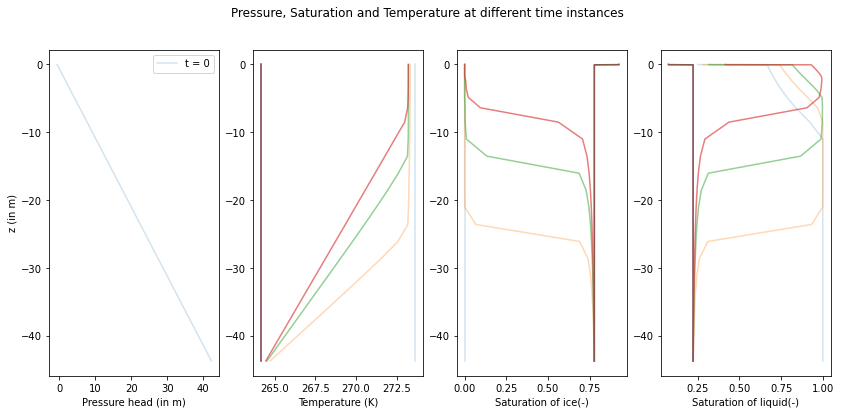

In [46]:
fig, (ax2, ax4, ax3,ax1) = plt.subplots(1, 4)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation and Temperature at different time instances')

z = df_saturation_liquid.index

#df_saturation_liquid = df_saturation_liquid.iloc[::-1]

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[16], z, alpha=0.8)
ax1.plot(df_saturation_liquid[21], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()

ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
#ax2.plot(pressure_head_data[4], z, alpha=0.3, label ='t = 4 ')
#ax2.plot(pressure_head_data[8], z, alpha=0.4, label ='t = 8 ')
#ax2.plot(pressure_head_data[12], z, alpha=0.6, label ='t = 12 ')
#ax2.plot(pressure_head_data[16], z, alpha=0.8, label ='t = 16 ')
#ax2.plot(pressure_head_data[21], z, alpha=1, label ='t = 21 (Total time)')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.set_ylabel('z (in m)')
ax2.legend()

ax3.plot(df_saturation_ice[0], z, alpha=0.2)
ax3.plot(df_saturation_ice[4], z, alpha=0.3)
ax3.plot(df_saturation_ice[8], z, alpha=0.5)
ax3.plot(df_saturation_ice[12], z, alpha=0.6)
ax3.plot(df_saturation_ice[16], z, alpha=0.8)
ax3.plot(df_saturation_ice[21], z, alpha=1)
#ax1.plot(df_saturation_ice[200], z, alpha=1)
#ax1.legend()
#ax3.set_ylabel('z (in m)')
ax3.set_xlabel('Saturation of ice(-)')

ax4.plot(df_temperature[0], z, alpha=0.2)
ax4.plot(df_temperature[4], z, alpha=0.3)
ax4.plot(df_temperature[8], z, alpha=0.5)
ax4.plot(df_temperature[12], z, alpha=0.6)
ax4.plot(df_temperature[16], z, alpha=0.8)
ax4.plot(df_temperature[21], z, alpha=1)
#ax1.plot(df_temperature[200], z, alpha=1)
#ax1.legend()
#ax4.set_ylabel('z (in m)')
ax4.set_xlabel('Temperature (K)')

### Plotting the changes near the surface

(-0.3, 0.0)

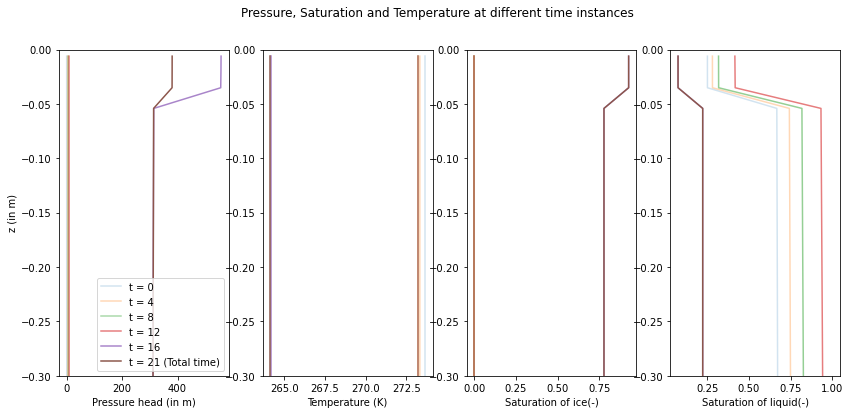

In [47]:
fig, (ax2, ax4, ax3,ax1) = plt.subplots(1, 4)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation and Temperature at different time instances')

z = df_saturation_liquid.index

#df_saturation_liquid = df_saturation_liquid.iloc[::-1]

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[16], z, alpha=0.8)
ax1.plot(df_saturation_liquid[21], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()
ax1.set_ylim(-0.3, 0.0)

ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
ax2.plot(pressure_head_data[4], z, alpha=0.3, label ='t = 4 ')
ax2.plot(pressure_head_data[8], z, alpha=0.4, label ='t = 8 ')
ax2.plot(pressure_head_data[12], z, alpha=0.6, label ='t = 12 ')
ax2.plot(pressure_head_data[16], z, alpha=0.8, label ='t = 16 ')
ax2.plot(pressure_head_data[21], z, alpha=1, label ='t = 21 (Total time)')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.set_ylabel('z (in m)')
ax2.legend()
ax2.set_ylim(-0.3, 0.0)

ax3.plot(df_saturation_ice[0], z, alpha=0.2)
ax3.plot(df_saturation_ice[4], z, alpha=0.3)
ax3.plot(df_saturation_ice[8], z, alpha=0.5)
ax3.plot(df_saturation_ice[12], z, alpha=0.6)
ax3.plot(df_saturation_ice[16], z, alpha=0.8)
ax3.plot(df_saturation_ice[21], z, alpha=1)
#ax1.plot(df_saturation_ice[200], z, alpha=1)
#ax1.legend()
#ax3.set_ylabel('z (in m)')
ax3.set_xlabel('Saturation of ice(-)')
ax3.set_ylim(-0.3, 0.0)

ax4.plot(df_temperature[0], z, alpha=0.2)
ax4.plot(df_temperature[4], z, alpha=0.3)
ax4.plot(df_temperature[8], z, alpha=0.5)
ax4.plot(df_temperature[12], z, alpha=0.6)
ax4.plot(df_temperature[16], z, alpha=0.8)
ax4.plot(df_temperature[21], z, alpha=1)
#ax1.plot(df_temperature[200], z, alpha=1)
#ax1.legend()
#ax4.set_ylabel('z (in m)')
ax4.set_xlabel('Temperature (K)')
ax4.set_ylim(-0.3, 0.0)

### 4. Preparing the final results as initial conditions for another model 

##### Column data as an example (for comparison later) - Pressure, temperature and 'z' value is needed

In [48]:
### Extracting the data from the example 'column_data.h5'.  
with h5py.File(f'column_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    pressure_column = np.array(hdf.get('pressure'))
    print(pressure_column)
    print(np.array(hdf.get('temperature')))
    print(np.array(hdf.get('z')))

List of datasets in this file: 
 
 ['pressure', 'temperature', 'z']


[-5715161.38222217   -38288.94464055  -137009.46125349  -303729.94754876
  -604598.55774324 -1359991.77832471 -2596737.52666966 -4390081.79553017
 -5899925.38370772 -2201592.7919399   -395567.94691654  -208693.39087789
  -106984.41961357   -37649.29204946    10003.73100321    42614.18374259
    65039.79466325    80682.27302661    92311.972959     227998.28604975
   368520.8505223    425196.35995214   448699.98231278   456942.84785056
   457954.83533019   456061.82400295   453760.93426082   452489.32873421
   453140.85676651   456234.79638825   462026.32667192   470512.04506409
   481399.31851633   494122.28984047   507898.01614843   521834.60226221
   535075.99445141   546946.19192434   557048.06020229   565285.52361617
   571808.38943001   576910.11783969   580922.4326558    584140.76186134
   586791.28979156   589030.36787342   590959.58325265   592643.21104279
   594122.35191633   595428.49402298   596724.59935131

##### Final results taken as initial conditions 

In [49]:
directory

'/home/rk/ats_rk/testing/ats-demos/rk_model/Case1_B/Case1_B_I.demo'

In [50]:
time_period.max()

2100

In [51]:
### Extracting the data from the example 'column_data.h5'.  
with h5py.File(f'{directory}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    
    # 
    pressure_column = np.array(hdf.get(f'pressure.cell.0/{time_period.max()}'))
    temperature_column = np.array(hdf.get(f'temperature.cell.0/{time_period.max()}'))


In [52]:
hf_input = h5py.File('IC_column_data_final.h5','w')

In [53]:
hf_input.create_dataset('z',data=z)
hf_input.create_dataset('pressure',data=pressure_column)
hf_input.create_dataset('temperature',data=temperature_column)

<HDF5 dataset "temperature": shape (40, 1), type "<f8">

In [54]:
hf_input.close()

In [55]:
### Reading the file once more to check if the data are stored accurately
# Storing the input data as a dataframe
with h5py.File(f'IC_column_data_final.h5','r') as hdf:
    ls = list(hdf.keys())
    pressure_column_data = np.array(hdf.get(f'pressure'))
    temperature_column_data = np.array(hdf.get(f'temperature'))

    
    input_data_hillslope = pd.DataFrame(index=np.arange(1,41,1),data=z,columns=['centroidal_distance'])
    input_data_hillslope['pressure'] = pressure_column_data
    input_data_hillslope['temperature'] = temperature_column_data
    input_data_hillslope.rename(columns={'centroidal_distance':'z'}, inplace=True)



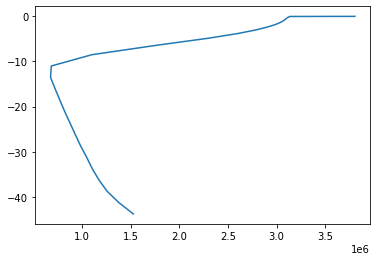

In [56]:
plt.plot(input_data_hillslope['pressure'], input_data_hillslope['z'])

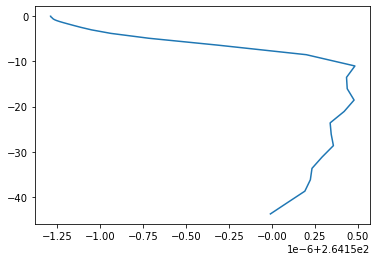

In [57]:
plt.plot(input_data_hillslope['temperature'], input_data_hillslope['z'])

#### 5. Plotting the observation results.

In [58]:
directory

'/home/rk/ats_rk/testing/ats-demos/rk_model/Case1_B/Case1_B_I.demo'

In [59]:
### Reading the observation files:
file_observation = '/home/rk/ats_rk/testing/ats-demos/rk_model/Case1_B/Case1_B_I.demo/observation.dat'

In [60]:
# Removing the hash lines in the intial part of the script
# https://stackoverflow.com/questions/11968998/remove-lines-that-contain-certain-string
remove_hashs = ['#']

# Opening the observation.dat file, 
# removing the lines with a hash and storing it in a new file - observation_2.dat
with open(f'{file_observation}') as oldfile, open('Case1_B_I.dat', 'w') as newfile:
    for line in oldfile:
        if not any(remove_hash in line for remove_hash in remove_hashs):
            newfile.write(line)

In [61]:
# Reading the csv file 
df_observation = pd.read_csv('Case1_B_I.dat',sep=' ')
df_observation['time [days]'] = df_observation['time [s]']/86400
df_observation.index = df_observation['time [days]']

df_observation.head()

,time [s],water content [mol],point -0.01 temperature [K],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],...,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice,time [days]
time [days],,,,,,,,,,,,,,,,,,,,,
0.00,0.0,1.197080e+06,273.650000,273.650000,273.650000,273.650000,273.650000,273.650000,273.650000,273.650000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
365.25,31557600.0,1.197080e+06,273.650001,273.650001,273.650001,273.650001,273.650001,273.650001,273.650001,273.650001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365.25
730.50,63115200.0,1.197080e+06,273.650000,273.650000,273.650000,273.650000,273.650000,273.650000,273.650000,273.650000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730.50
1095.75,94672800.0,1.197080e+06,273.649997,273.649997,273.649997,273.649997,273.649997,273.649997,273.649997,273.649996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1095.75
1461.00,126230400.0,1.197080e+06,273.649971,273.649971,273.649971,273.649971,273.649971,273.649970,273.649968,273.649965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1461.00


#### Plotting the values 
##### 1. Subsurface temperature

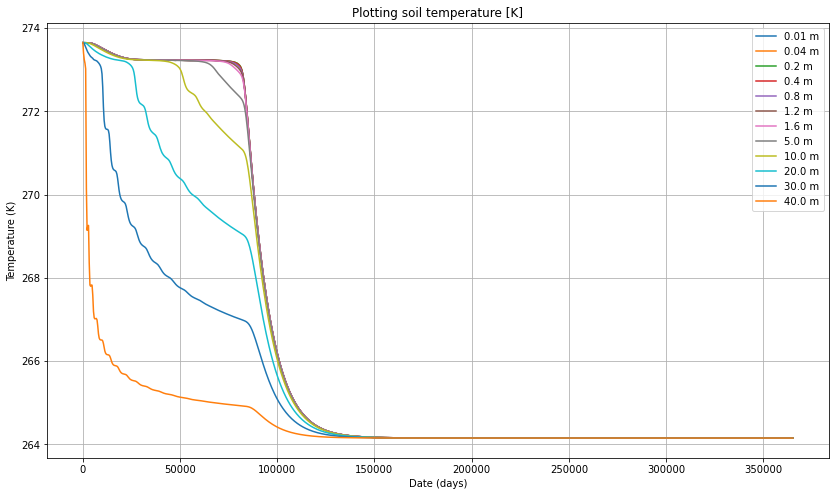

In [62]:
plt.figure(figsize=(14,8))
plt.title('Plotting soil temperature [K]')
plt.plot(df_observation['point -0.01 temperature [K]'],label='0.01 m')
plt.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
plt.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
plt.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
plt.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
plt.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
plt.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
plt.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
plt.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
plt.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
plt.plot(df_observation['point -30.0 temperature [K]'],label='30.0 m')
plt.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')

plt.ylabel('Temperature (K)')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlabel('Date (days)')
plt.legend()
plt.grid(True)

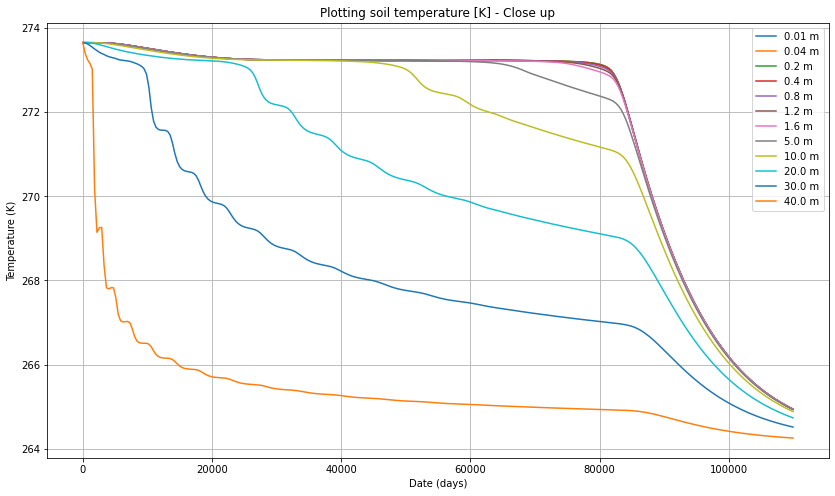

In [63]:
plt.figure(figsize=(14,8))
plt.title('Plotting soil temperature [K] - Close up')
plt.plot(df_observation['point -0.01 temperature [K]'][:110000],label='0.01 m')
plt.plot(df_observation['point -0.04 temperature [K]'][:110000],label='0.04 m')
plt.plot(df_observation['point -0.2 temperature [K]'][:110000],label='0.2 m')
plt.plot(df_observation['point -0.4 temperature [K]'][:110000],label='0.4 m')
plt.plot(df_observation['point -0.8 temperature [K]'][:110000],label='0.8 m')
plt.plot(df_observation['point -1.2 temperature [K]'][:110000],label='1.2 m')
plt.plot(df_observation['point -1.6 temperature [K]'][:110000],label='1.6 m')
plt.plot(df_observation['point -5.0 temperature [K]'][:110000],label='5.0 m')
plt.plot(df_observation['point -10.0 temperature [K]'][:110000],label='10.0 m')
plt.plot(df_observation['point -20.0 temperature [K]'][:110000],label='20.0 m')
plt.plot(df_observation['point -30.0 temperature [K]'][:110000],label='30.0 m')
plt.plot(df_observation['point -40.0 temperature [K]'][:110000],label='40.0 m')
plt.ylabel('Temperature (K)')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlabel('Date (days)')
plt.legend()
plt.grid(True)

#### Plotting the values 
##### 2. Saturation of liquid

In [64]:
df_observation.columns

Index(['time [s]', 'water content [mol]', 'point -0.01 temperature [K]',
       'point -0.04 temperature [K]', 'point -0.1 temperature [K]',
       'point -0.2 temperature [K]', 'point -0.4 temperature [K]',
       'point -0.8 temperature [K]', 'point -1.2 temperature [K]',
       'point -1.6 temperature [K]', 'point -5.0 temperature [K]',
       'point -10.0 temperature [K]', 'point -20.0 temperature [K]',
       'point -30.0 temperature [K]', 'point -40.0 temperature [K]',
       'point -0.01 saturation liquid', 'point -0.04 saturation liquid',
       'point -0.1 saturation liquid', 'point -0.2 saturation liquid',
       'point -0.4 saturation liquid', 'point -0.8 saturation liquid',
       'point -1.2 saturation liquid', 'point -1.6 saturation liquid',
       'point -5.0 saturation liquid', 'point -10.0 saturation liquid',
       'point -0.01 saturation ice', 'point -0.04 saturation ice',
       'point -0.1 saturation ice', 'point -0.2 saturation ice',
       'point -0.4 saturation 

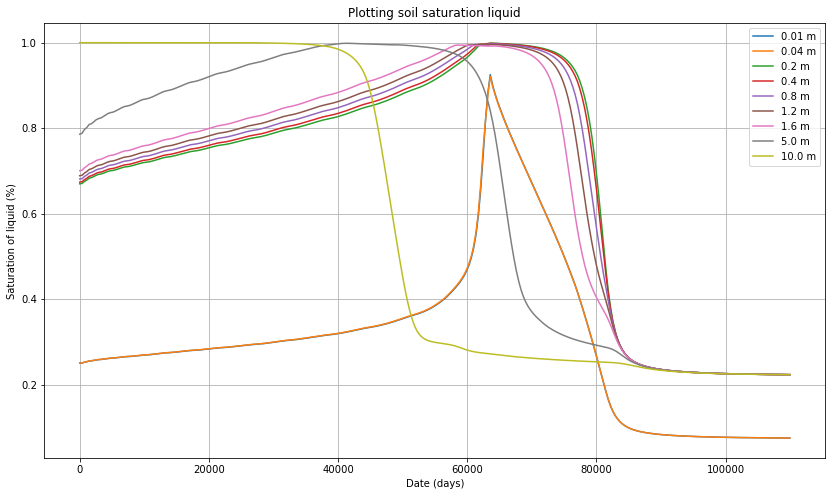

In [65]:
plt.figure(figsize=(14,8))
plt.title('Plotting soil saturation liquid')
plt.plot(df_observation['point -0.01 saturation liquid'][:110000],label='0.01 m')
plt.plot(df_observation['point -0.04 saturation liquid'][:110000],label='0.04 m')
plt.plot(df_observation['point -0.2 saturation liquid'][:110000],label='0.2 m')
plt.plot(df_observation['point -0.4 saturation liquid'][:110000],label='0.4 m')
plt.plot(df_observation['point -0.8 saturation liquid'][:110000],label='0.8 m')
plt.plot(df_observation['point -1.2 saturation liquid'][:110000],label='1.2 m')
plt.plot(df_observation['point -1.6 saturation liquid'][:110000],label='1.6 m')
plt.plot(df_observation['point -5.0 saturation liquid'][:110000],label='5.0 m')
plt.plot(df_observation['point -10.0 saturation liquid'][:110000],label='10.0 m')

plt.ylabel('Saturation of liquid (%)')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlabel('Date (days)')
plt.legend()
plt.grid(True)

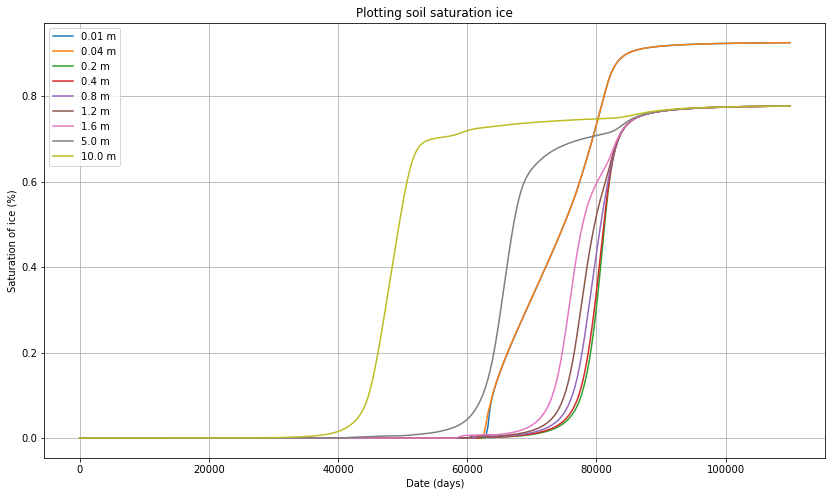

In [66]:
plt.figure(figsize=(14,8))
plt.title('Plotting soil saturation ice')
plt.plot(df_observation['point -0.01 saturation ice'][:110000],label='0.01 m')
plt.plot(df_observation['point -0.04 saturation ice'][:110000],label='0.04 m')
plt.plot(df_observation['point -0.2 saturation ice'][:110000],label='0.2 m')
plt.plot(df_observation['point -0.4 saturation ice'][:110000],label='0.4 m')
plt.plot(df_observation['point -0.8 saturation ice'][:110000],label='0.8 m')
plt.plot(df_observation['point -1.2 saturation ice'][:110000],label='1.2 m')
plt.plot(df_observation['point -1.6 saturation ice'][:110000],label='1.6 m')
plt.plot(df_observation['point -5.0 saturation ice'][:110000],label='5.0 m')
plt.plot(df_observation['point -10.0 saturation ice'][:110000],label='10.0 m')

plt.ylabel('Saturation of ice (%)')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlabel('Date (days)')
plt.legend()
plt.grid(True)

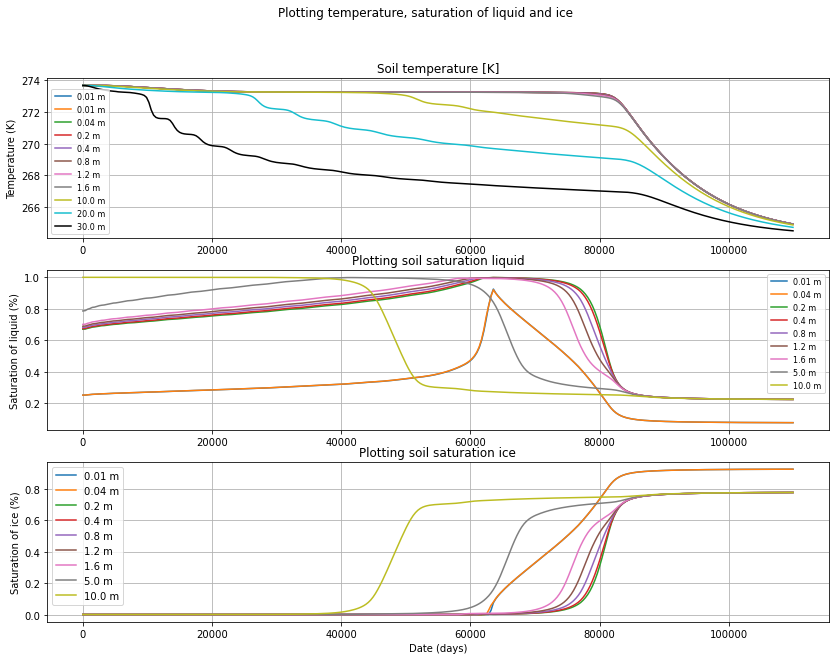

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature, saturation of liquid and ice')

ax1.set_title('Soil temperature [K]')
ax1.plot(df_observation['point -0.01 temperature [K]'][:110000],label='0.01 m')
ax1.plot(df_observation['point -0.01 temperature [K]'][:110000],label='0.01 m')
ax1.plot(df_observation['point -0.04 temperature [K]'][:110000],label='0.04 m')
ax1.plot(df_observation['point -0.2 temperature [K]'][:110000],label='0.2 m')
ax1.plot(df_observation['point -0.4 temperature [K]'][:110000],label='0.4 m')
ax1.plot(df_observation['point -0.8 temperature [K]'][:110000],label='0.8 m')
ax1.plot(df_observation['point -1.2 temperature [K]'][:110000],label='1.2 m')
ax1.plot(df_observation['point -1.6 temperature [K]'][:110000],label='1.6 m')
#ax1.plot(df_observation['point -5.0 temperature [K]'][:110000],label='5.0 m')
ax1.plot(df_observation['point -10.0 temperature [K]'][:110000],label='10.0 m')
ax1.plot(df_observation['point -20.0 temperature [K]'][:110000],label='20.0 m')
ax1.plot(df_observation['point -30.0 temperature [K]'][:110000],'k',label='30.0 m')
#ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')

ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
ax2.plot(df_observation['point -0.01 saturation liquid'][:110000],label='0.01 m')
ax2.plot(df_observation['point -0.04 saturation liquid'][:110000],label='0.04 m')
ax2.plot(df_observation['point -0.2 saturation liquid'][:110000],label='0.2 m')
ax2.plot(df_observation['point -0.4 saturation liquid'][:110000],label='0.4 m')
ax2.plot(df_observation['point -0.8 saturation liquid'][:110000],label='0.8 m')
ax2.plot(df_observation['point -1.2 saturation liquid'][:110000],label='1.2 m')
ax2.plot(df_observation['point -1.6 saturation liquid'][:110000],label='1.6 m')
ax2.plot(df_observation['point -5.0 saturation liquid'][:110000],label='5.0 m')
ax2.plot(df_observation['point -10.0 saturation liquid'][:110000],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)


ax3.set_title('Plotting soil saturation ice')
ax3.plot(df_observation['point -0.01 saturation ice'][:110000],label='0.01 m')
ax3.plot(df_observation['point -0.04 saturation ice'][:110000],label='0.04 m')
ax3.plot(df_observation['point -0.2 saturation ice'][:110000],label='0.2 m')
ax3.plot(df_observation['point -0.4 saturation ice'][:110000],label='0.4 m')
ax3.plot(df_observation['point -0.8 saturation ice'][:110000],label='0.8 m')
ax3.plot(df_observation['point -1.2 saturation ice'][:110000],label='1.2 m')
ax3.plot(df_observation['point -1.6 saturation ice'][:110000],label='1.6 m')
ax3.plot(df_observation['point -5.0 saturation ice'][:110000],label='5.0 m')
ax3.plot(df_observation['point -10.0 saturation ice'][:110000],label='10.0 m')

ax3.set_ylabel('Saturation of ice (%)')
#ax3.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax3.set_xlabel('Date (days)')
ax3.legend()
ax3.grid(True)